# test_eqt_preprocesses.ipynb
***auth*:  Nathan T. Stevens**  
***org*:   Pacific Northwest Seismic Network (PNSN)**  
***email*: ntsteven@uw.edu**  

***purpose***  

This notebook is used as an intermediate development step for scripts running an intercomparison of pre-processing and instrument-type influences on machine learning (ML) based earthquake detection and phase arrival time picking/classification using the EarthQuake Transformer (`EQTransformer` / EQT) algorithm of Mousavi et al. (2020), its original model weights trained on the `STEAD` data set (Mousavi et al., 2019), and model weights trained on the AI-ready Pacific Northwest Dataset (PNW Store) of Ni et al. (2023).  

We apply in-house data preparation codes documented in this repository `PNSN/Sci-Prod-ML` to curate data collections directly from the ANSS comprehensive catalog (ComCat) and cataloged waveforms accessed via the FDSN using `ObsPy`. Prediction routines are conducted using `SeisBench` (Woollam et al., 2022).

For PSNS purposes, our goals are to constrain the trade-off in pre-processing complexity (called `generator pipelines` in ML jargon) for introduction to EQT, training model selection, and instrument type. This stems from the question of if we can better leverage accelerometer data that are currently not considered in PNSN Earthworm-facilitated automated detection and picking pipelines to improve event localization from stations in high-noise settings (i.e., urban centers). 


**Notes on preprocessing of `BH?` data in Ni et al. (2023)**  

> *We first curate waveforms fromhigh-gain velocity seismometers and specific channelsfrom short-period (EH?) and broad-band (either BH?or HH?) seismometers.  We do not use the SL? andSH? channels since they are simply derived from EH?channel after low-pass filtering or down-sampling. Wealso include waveforms from strong-motion EN? sta-tions separately since there are also picks made on thesechannels by the analysts. We do not correct for instru-mental response and do not integrate the accelerationto velocity. All waveforms are resampled to 100 Hz fromtheir original sampling rates, which may be 40 (mostBH? channels) or 100 (most EH? and HH? channels).*

- Ni et al. (2023, Seismica) Data Selection & Preparation --> Waveform Events 



**References**  

Mousavi, S. M., Sheng, Y., Zhu, W., and Beroza, G. C.  STanfordEArthquakeDataset(STEAD):Aglobaldatasetofseismic signalsfor AI.IEEE Access, 7:179464–179476, 2019. doi:10.1109/AC-CESS.2019.2947848.

Mousavi, S. M., Ellsworth, W. L., Zhu, W., Chuang, L. Y., andBeroza, G. C.   Earthquake transformer—an attentive deep-learning model for simultaneous earthquake detection andphase picking.Nature communications, 11(1):1–12, 2020. doi:10.1038/s41467-020-17591-w.

Ni, Yiyu, Alexander Hutko, Francesca Skene, Marine Denolle, Stephen Malone, Paul Bodin, Renate Hartog, and Amy Wright. “Curated Pacific Northwest AI-Ready Seismic Dataset.” Seismica 2, no. 1 (May 8, 2023). https://doi.org/10.26443/seismica.v2i1.368.

Woollam, J., Münchmeyer, J., Tilmann, F., Rietbrock, A., Lange, D.,Bornstein, T., Diehl, T., Giunchi, C., Haslinger, F., Jozinović, D.,et al. SeisBench—A toolbox for machine learning in seismology.Seismological Society of America, 93(3):1695–1709, 2022. doi:10.1785/0220210324.


**Data Sources**  
University of Washington.  Pacific Northwest Seismic Network- University of Washington, 1963.https://www.fdsn.org/networks/detail/UW/.

Ni, Y. niyiyu/PNW-ML: PNW-ML Seismic Dataset. doi:10.5281/zen-odo.7627103.


In [21]:
import os
import sys
from glob import glob
from tqdm import tqdm
from seisbench.models import EQTransformer, WaveformModel
sys.path.append(os.path.join('..','..'))
import query.verboseevent as qve
from util.preprocess import split_streams, order_traces
from util.translate import relabel_annotations
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load Event Data
event_archives = glob(os.path.join('.','data','*'))
event_archives.sort()

ve_list = []
for f_ in tqdm(event_archives):
    _ve = qve.VerboseEvent()
    _ve.from_layered_directory(f_)
    ve_list.append(_ve)

vcat = qve.VerboseCatalog(verbose_catalog_list=ve_list)

# Get indices for 5 highes magnitude events
eve_inds = vcat.summary.sort_values('Magnitude', ascending=False).index[:5]

100%|██████████| 59/59 [00:00<00:00, 997838.45it/s]


In [3]:
# Instantiate the EQTransformer model(s)
model_pnw = EQTransformer.from_pretrained('pnw')
model_ste = EQTransformer.from_pretrained('stead')
# Create dictionary keyed with training data codes
mod_dict = {'D': model_ste, 'W': model_pnw}

In [4]:
# Create start of directory structure
try:
    os.mkdir(os.path.join('.','processed_data'))
except FileExistsError:
    pass

In [5]:
# Subset to the largest event
# but maintain syntax that will be easy to wrap subsequent steps in a `for` loop
_ei = eve_inds[0]
_ve = vcat.events[_ei]
try:
    os.mkdir(os.path.join('.','processed_data',_ve.event.id))
except FileExistsError:
    pass

In [9]:
# split stream into instrument sets & reorder for ZNE
streams = split_streams(_ve.waveforms)
display(streams)
streams['BH'][0].stats

{'BH': 3 Trace(s) in Stream:
UW.GNW..BHE | 2017-05-11T07:32:54.730000Z - 2017-05-11T07:38:15.430000Z | 40.0 Hz, 12829 samples
UW.GNW..BHN | 2017-05-11T07:32:54.730000Z - 2017-05-11T07:38:15.430000Z | 40.0 Hz, 12829 samples
UW.GNW..BHZ | 2017-05-11T07:32:54.730000Z - 2017-05-11T07:38:15.430000Z | 40.0 Hz, 12829 samples,
 'EN': 3 Trace(s) in Stream:
UW.GNW..ENE | 2017-05-11T07:32:54.725000Z - 2017-05-11T07:38:15.435000Z | 100.0 Hz, 32072 samples
UW.GNW..ENN | 2017-05-11T07:32:54.725000Z - 2017-05-11T07:38:15.435000Z | 100.0 Hz, 32072 samples
UW.GNW..ENZ | 2017-05-11T07:32:54.725000Z - 2017-05-11T07:38:15.435000Z | 100.0 Hz, 32072 samples}

         network: UW
         station: GNW
        location: 
         channel: BHE
       starttime: 2017-05-11T07:32:54.730000Z
         endtime: 2017-05-11T07:38:15.430000Z
   sampling_rate: 40.0
           delta: 0.025
            npts: 12829
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 33, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 133120})

# START OF ML PREDICTION WORKFLOW
## Sections
1. Broadband data performance comparison
    a. Can we precisely reproduce ML picks presented by Ni et al. (2023)?
    b. How do ML picks compare by removing elements of their generator pipeline?
    c. What are the compute overhead/precision tradeoffs from removing these elements?
2. Accelerometer data performance comparison
    a. Experiment 1: use raw 

## Potential pre-processing elements to test
Presently, data coming from 6C stations like UW.GNW is sampled at 40 Hz for BH? channels and 100 Hz for EN? channels. Compared to the standard 100 Hz resampled data archive provided by Ni and others (2023, Seismica).

 + **Resample** to:
    1. Native (don't resample) - requires a longer data-stream to hit 6000 samples
    2. 100 Hz - Match training data of Ni and others (2023)
    3. 200 Hz - see if we can get away with less data? (i.e., shorter data packets)
 + **Filter** with:
    1. Downsampling of *EN?* data requires a 40 Hz lowpass filter
    2. What other filtering might be relevant? What does SeisBench do, if anything?
 + **Response Removal**:
    1. Does deconvolving instrument response change 

In [18]:
# Take steps to re-create results from Ni et al. (2023)
st = streams['BH']
display(st)
# Resample data to 100 Hz, no instrument correction, no filtering
st100 = st.copy().resample(100)
display(st100)

3 Trace(s) in Stream:
UW.GNW..BHE | 2017-05-11T07:32:54.730000Z - 2017-05-11T07:38:15.430000Z | 40.0 Hz, 12829 samples
UW.GNW..BHN | 2017-05-11T07:32:54.730000Z - 2017-05-11T07:38:15.430000Z | 40.0 Hz, 12829 samples
UW.GNW..BHZ | 2017-05-11T07:32:54.730000Z - 2017-05-11T07:38:15.430000Z | 40.0 Hz, 12829 samples

3 Trace(s) in Stream:
UW.GNW..BHE | 2017-05-11T07:32:54.730000Z - 2017-05-11T07:38:15.440000Z | 100.0 Hz, 32072 samples
UW.GNW..BHN | 2017-05-11T07:32:54.730000Z - 2017-05-11T07:38:15.440000Z | 100.0 Hz, 32072 samples
UW.GNW..BHZ | 2017-05-11T07:32:54.730000Z - 2017-05-11T07:38:15.440000Z | 100.0 Hz, 32072 samples

In [20]:
# Conduct Predictions on both
BH040_W_ann = mod_dict['W'].annotate(st)
BH040_D_ann = mod_dict['D'].annotate(st)
BH100_W_ann = mod_dict['W'].annotate(st100)
BH100_D_ann = mod_dict['D'].annotate(st100)

/Users/nates/miniforge3/envs/pnsn_ml_dev_apple/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


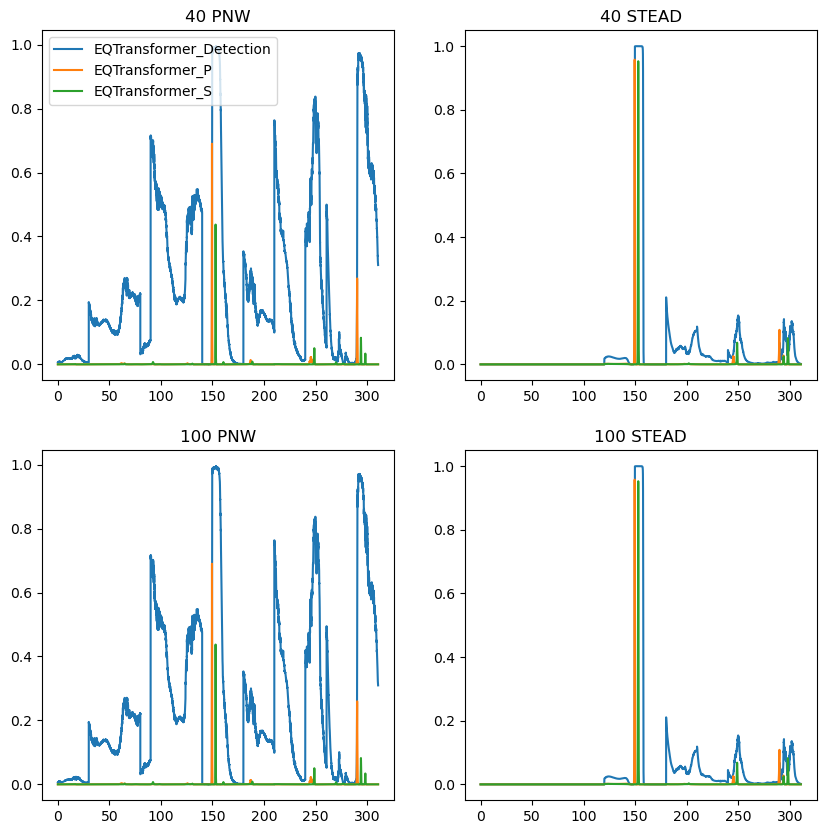

In [23]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(ncols=2,nrows=2)
axs = [fig.add_subplot(gs[x]) for x in range(4)]
dats = [BH040_W_ann, BH040_D_ann, BH100_W_ann, BH100_D_ann]
for _i, _ax in enumerate(axs):
    _dat = dats[_i]
    for _tr in _dat:
        _ax.plot(_tr.times(), _tr.data, label=_tr.stats.channel)
    if _i < 2:
        sr = 40
    else:
        sr = 100
    if _i % 2 == 0:
        mo = 'PNW'
    else:
        mo = 'STEAD'
    if _i == 0:
        _ax.legend()
    _ax.set_title(f'{sr} {mo}')

